In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = False
load_gsea = False
load_gsea_heatmap = False
run_umap = True

In [2]:
backup_dir = '/root/datos/maestria/netopaas/luca/data/atlas/'
id_ = 'extended'

# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
time = 'III-IVless'
adata = sc.read_h5ad(f'{backup_dir}/{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'is_highly_v

In [5]:
adata = adata[(adata.obs.origin == 'tumor_primary')]

In [6]:
adata = adata[np.logical_or(adata.obs.uicc_stage == 'III', adata.obs.uicc_stage == 'III or IV', adata.obs.uicc_stage == 'IV')]

In [7]:
adata.layers['counts_length_scaled'][:30,:30].to_df()

gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000124608,ENSG00000266967,ENSG00000157426,ENSG00000149313,ENSG00000008311,ENSG00000215458,ENSG00000275700,ENSG00000181409,ENSG00000281376,ENSG00000183044
AAACCCAAGAGCCATG-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.315395
AAACCCAAGATTAGAC-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.252197,0.0,0.000000,0.000000,0.0,...,0.0,0.252197,0.000000,0.252197,0.0,0.0,0.252197,0.000000,0.0,0.000000
AAACCCAAGGTCGCCT-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.966521,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCAAGTCATTGC-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.778732,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCACACGGATCC-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.504331,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCACACTCCTTG-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCACATCTATCT-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.499564
AAACCCAGTACGATTC-1_0-1,0.0,0.0,1.192085,0.0,0.0,0.000000,0.0,0.000000,1.192085,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCAGTGATAGTA-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
AAACCCAGTGTATTGC-1_0-1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000


Sadly we must eliminate Guo and Leadder studies becuase they are CD45 (lymphocyte makrer) enriched. Also Goveia is CD31 (endthelial cells) enriched.

In [6]:
adata = adata[np.logical_not(np.logical_or(adata.obs.study == 'Goveia_Carmeliet_2020', adata.obs.study == 'Leader_Merad_2021', adata.obs.study == 'Guo_Zhang_2018'))]

In [7]:
adata.var['ens'] = adata.var.index
adata.var.index = adata.var.feature_name

/tmp/ipykernel_145298/481543411.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ens'] = adata.var.index


## Marker Genes

We use th wilcoxon paired metho beacuse it considers hetorgeneity in te cell abundances. The one group vs rest does not do this.
So the idea is to first make all the pairwise comparisons and then do a summary of the stasticstics.

For that we have a method that automatically does the pairwise of a list of groups you give.

Then we choose the Rest Group and gather its stasticis in `.uns` key.  And then we have a method that takes the mean of those stastisitcs and outputs marker genes for every cell type vs. its rest.

In [9]:
adata.obs['type_tissue'] = adata.obs['cell_type_tumor']

### Pairwise

With parallel is shit! With 4 groups and 12 jobs it takes 26 min

Without parallel, still runs parallel from nnumpy in the scanpy method. With 4 groups it takes 12 min

TODO: Limit the number of cores this uses https://stackoverflow.com/questions/55746872/how-to-limit-number-of-cpus-used-by-a-python-script-w-o-terminal-or-multiproces

In [12]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
types = adata.obs.type_tissue.cat.categories
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/{time}_{id_}'
key_pair = "rank_genes_groups_pairwise"

In [13]:
%%time
#papermill_description=wilcoxon_DE

if load_wilcoxon:
    adata.uns[key_pair] = np.load(all_path + '_pair.npy', allow_pickle='TRUE').item()
else:
    # TODO Adress this: is sensitive to the population composition, which introduces an element of unpredictability to the marker sets due to variation in cell type abundances
    # Solved by using pairwise wilcoxon
    results = ut.rank_genes_groups_pairwise(adata, 'type_tissue', method='wilcoxon', use_raw=False,
                       groups=valid_types, parallel=False)
    adata.uns[key_pair] = results
    np.save(all_path + '_pair.npy', adata.uns[key_pair])

[('T cell CD4', 'Macrophage'), ('T cell CD4', 'Tumor cells LUSC'), ('T cell CD4', 'Tumor cells LUAD'), ('T cell CD4', 'T cell CD8 effector memory'), ('T cell CD4', 'Tumor cells LUSC mitotic'), ('T cell CD4', 'T cell regulatory'), ('T cell CD4', 'Tumor cells LUAD EMT'), ('T cell CD4', 'B cell'), ('T cell CD4', 'Plasma cell'), ('T cell CD4', 'T cell CD8 terminally exhausted'), ('T cell CD4', 'transitional club/AT2'), ('T cell CD4', 'NK cell'), ('T cell CD4', 'Monocyte classical'), ('T cell CD4', 'Macrophage alveolar'), ('T cell CD4', 'Fibroblast peribronchial'), ('T cell CD4', 'cDC2'), ('T cell CD4', 'Tumor cells LUAD mitotic'), ('T cell CD4', 'Alveolar cell type 2'), ('T cell CD4', 'Neutrophils'), ('T cell CD4', 'Mast cell'), ('T cell CD4', 'Tumor cells NSCLC mixed'), ('T cell CD4', 'Endothelial cell venous'), ('T cell CD4', 'myeloid dividing'), ('T cell CD4', 'T cell NK-like'), ('T cell CD4', 'Ciliated'), ('T cell CD4', 'Pericyte'), ('T cell CD4', 'T cell CD8 naive'), ('T cell CD4', 'T

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/

CPU times: user 6h 4min 56s, sys: 54min 50s, total: 6h 59min 46s
Wall time: 6h 58min 33s


### Summaries

In [14]:
results = adata.uns[key_pair]

In [15]:
import multiprocessing
def process_gene(group1, pairwise_dict, groups2):
    scores = {}
    genes = next(iter(results.items()))[1]['names']
    comparisons = [(group1, group2) for group2 in groups2 if group1 != group2]
    
    for gene in genes:
        comparison_scores = []
        for comparison in comparisons:
            comp_key = f'{comparison[0]}_vs_{comparison[1]}'
            gene_index = np.where(results[comp_key]['names'] == gene)[0]
            comparison_scores.append(results[comp_key]['scores'][gene_index][0])
        scores[gene] = comparison_scores
    return group1, scores

num_processes = 40

Only Normal

In [16]:
%%time
groups = [ group for group in valid_types if 'Tumor' not in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, groups) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_onlynormal'] = scores_dict

CPU times: user 4min 31s, sys: 2min 5s, total: 6min 36s
Wall time: 12min 33s


Normal all

In [17]:
%%time
groups = [ group for group in valid_types if 'Tumor' not in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_normalall'] = scores_dict

CPU times: user 4min 17s, sys: 2min 12s, total: 6min 30s
Wall time: 14min 33s


Only Tumor

In [18]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, groups) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_onlytumor'] = scores_dict

CPU times: user 40.1 s, sys: 46 s, total: 1min 26s
Wall time: 2min 30s


Tumor against all

In [19]:
%%time
groups = [ group for group in valid_types if 'Tumor' in group]
scores_dict = {group: {} for group in groups}

with multiprocessing.Pool(num_processes) as pool:
    for group_scores in pool.starmap(process_gene, [(group1, results, valid_types) for group1 in groups]):
        scores_dict[group_scores[0]] = group_scores[1]

adata.uns['rank_genes_groups_summary_tumorall'] = scores_dict

CPU times: user 41 s, sys: 41.4 s, total: 1min 22s
Wall time: 7min 35s


We make it mimic the structure that the scanpy tool for ranking genes already has to be able to work with our other methods.

In [44]:
regions = ['onlynormal', 'onlytumor', 'tumorall', 'normalall']

In [20]:
%%time
regions = ['onlynormal', 'onlytumor', 'tumorall', 'normalall']
# regions = ['normalall']

for region in regions:
    if load_wilcoxon:
        adata.uns[f'rank_genes_groups_{region}'] = np.load(all_path + f'_{region}.npy', allow_pickle=True).item()
        continue

    regioner = {cell_type: {gene: np.mean(scores) for gene, scores in genes_dict.items()}
                    for cell_type, genes_dict in adata.uns[f'rank_genes_groups_summary_{region}'].items()}
    regioner = {cell_type: sorted(genes.items(), key=lambda k: k[1], reverse=True) for cell_type, genes in regioner.items()}

    types_num = len(regioner)
    genes_num = len(next(iter(results.values()))['names'])
    scores = [[None] * genes_num for _ in range(types_num)]
    names = [[None] * genes_num for _ in range(types_num)]
    
    for i, cell_type in enumerate(regioner.keys()):
        j = 0
        for gene, score in regioner[cell_type]:
            scores[i][j] = score
            names[i][j] = gene
            j += 1

    names_zip = list(zip(*names))
    dtypes = [(typer, float) for typer in regioner.keys()]
    dtypes_names = [(typer, 'O') for typer in regioner.keys()]

    i = 0
    for n_scores in zip(*scores):
        if i==0:
            rank_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
        else:
            temp_scores = np.rec.array([n_scores], dtype=dtypes)
            rank_scores = np.rec.array(np.concatenate((rank_scores, temp_scores)))
    
            temp_names = np.rec.array([names_zip[i]], dtype=dtypes_names)
            rank_names = np.rec.array(np.concatenate((rank_names, temp_names)))
        i += 1

    rec_region = {'params': {'groupby': 'type_tissue', 'reference': region, 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}}
    rec_region['names'] = rank_names
    rec_region['scores'] = rank_scores

    adata.uns[f'rank_genes_groups_{region}'] = rec_region
    np.save(all_path + f'_{region}.npy', adata.uns[f'rank_genes_groups_{region}'])

CPU times: user 17min 30s, sys: 7.58 s, total: 17min 37s
Wall time: 17min 35s


In [33]:
[ keyer  for keyer in adata.uns.keys() if 'rank_genes' in keyer]

['rank_genes_groups_pairwise',
 'rank_genes_groups_summary_onlynormal',
 'rank_genes_groups_summary_normalall',
 'rank_genes_groups_summary_onlytumor',
 'rank_genes_groups_summary_tumorall',
 'rank_genes_groups_normalall']

### Plotting

In [21]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # pass
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

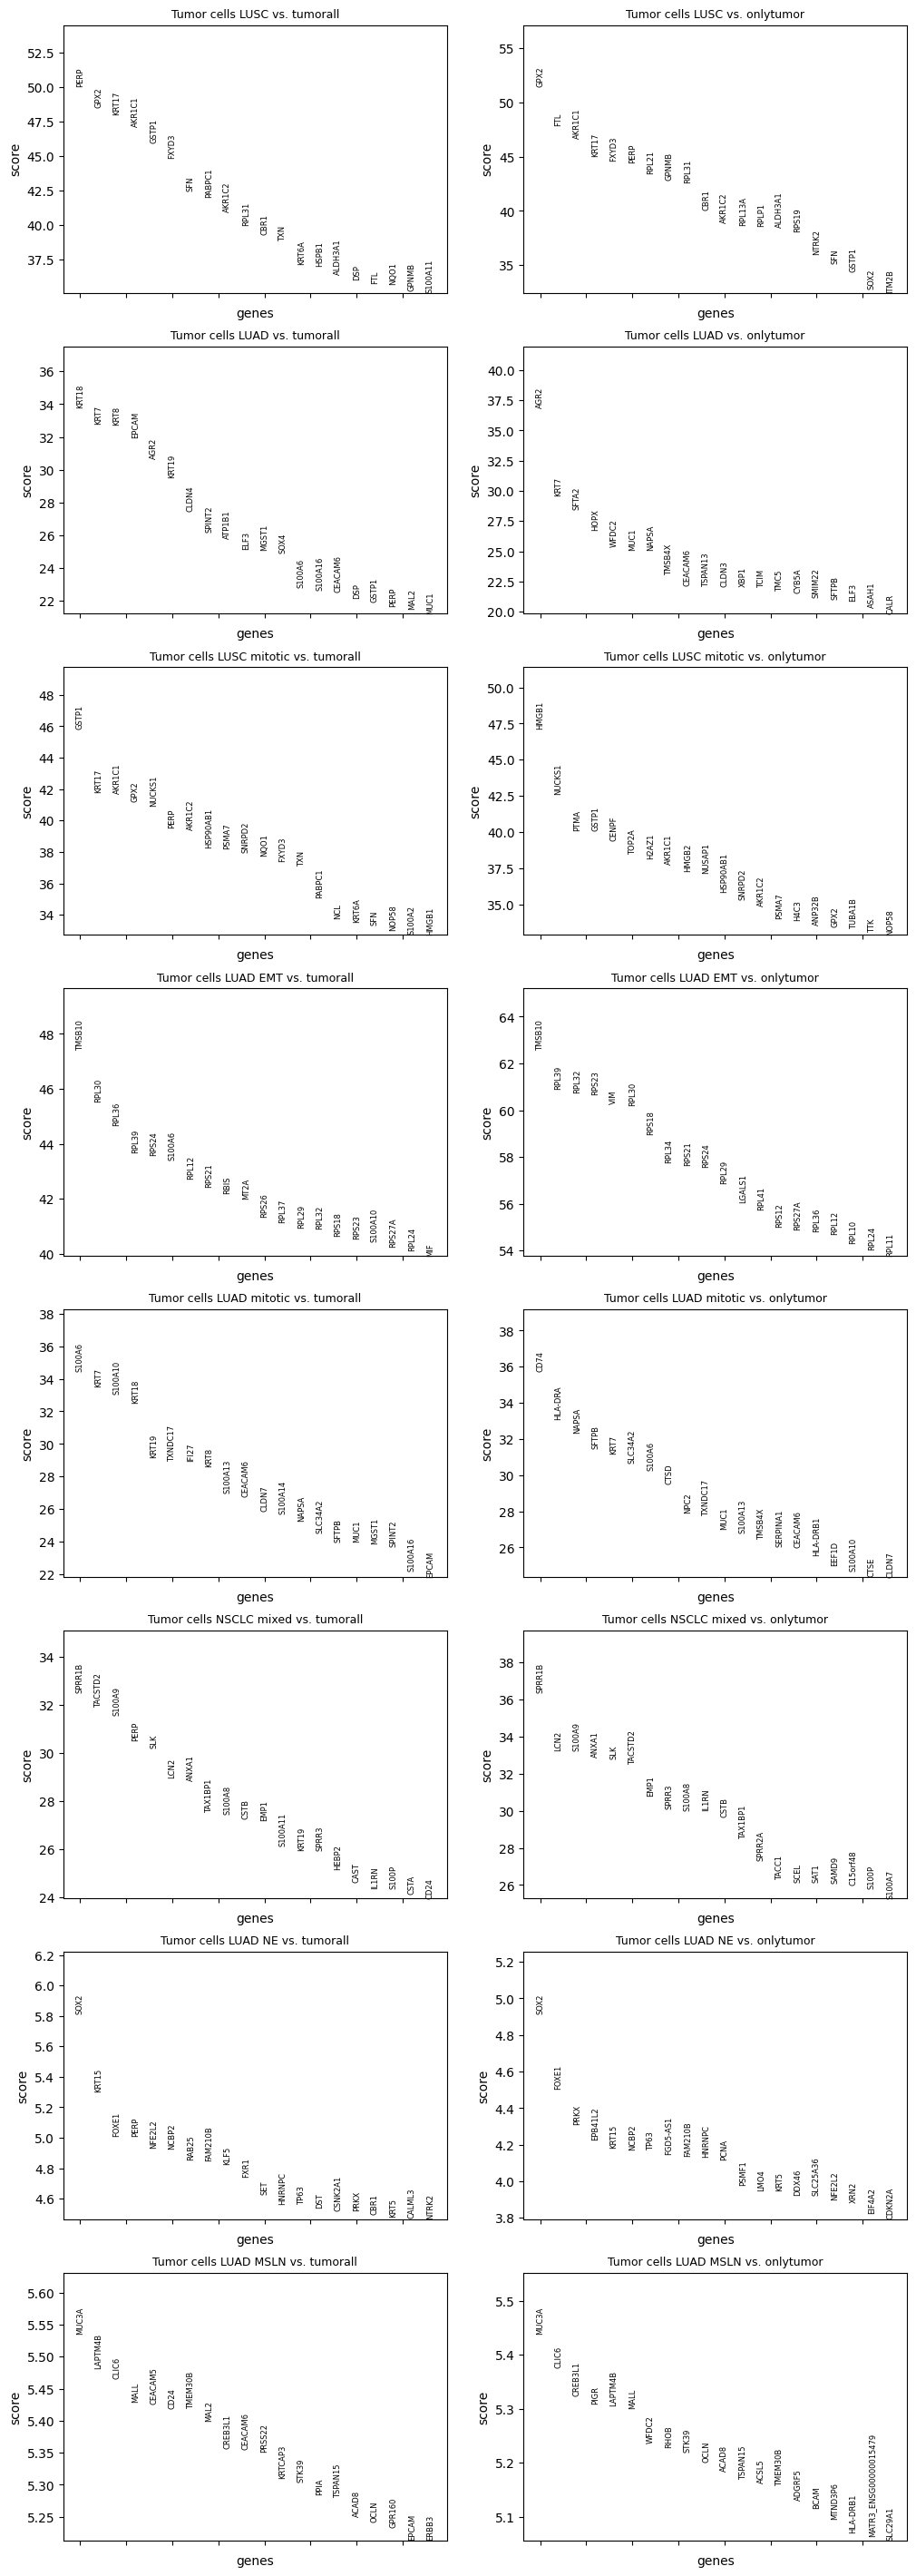

In [36]:
region = 'tumorall'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*(num_types)))
n_genes = 20
for i, type in enumerate(types):
    # tumor_tumor = type + '_TT_Tumor'
    # normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i, 0], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i, 1], sharey=False, key=f'rank_genes_groups_onlytumor', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 21

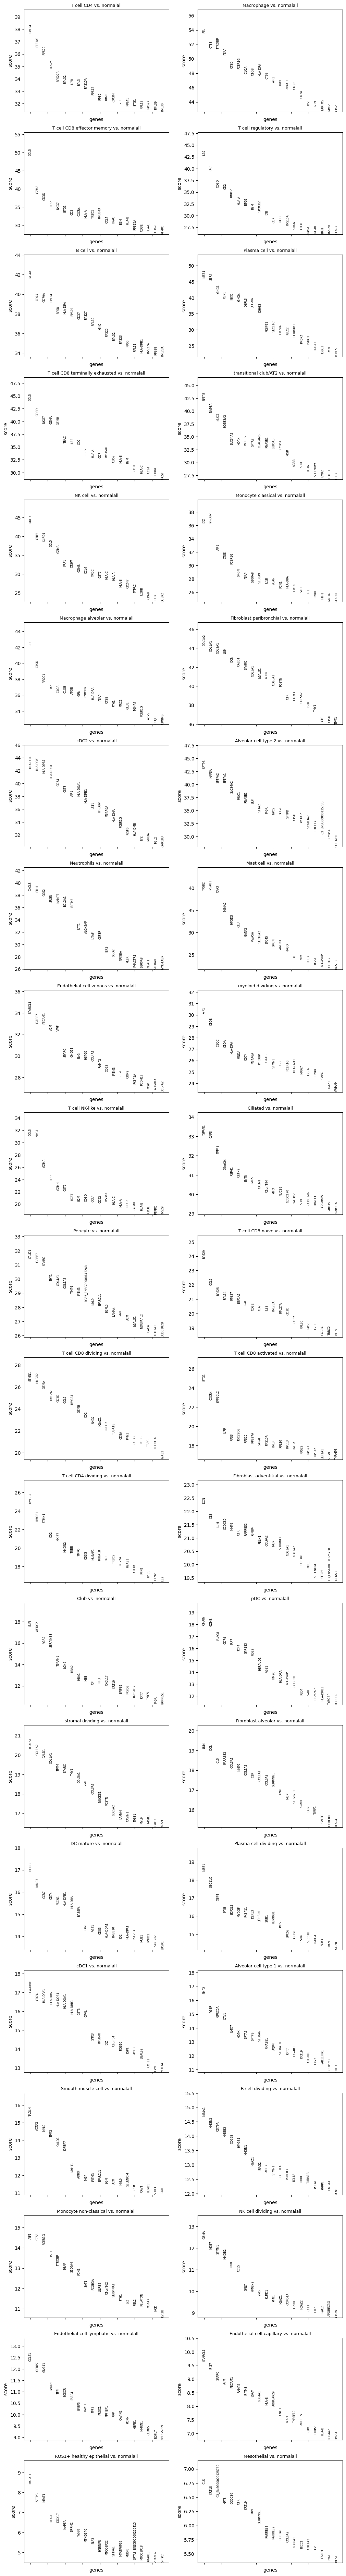

In [37]:
region = 'normalall'
types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
num_types = len(types)
fig, axs = plt.subplots(num_types//2, 2, figsize=(12, 4.5*(num_types/2)))
n_genes = 20
for i, type in enumerate(types):
    # tumor_tumor = type + '_TT_Tumor'
    # normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, [type], valid_types, n_genes=n_genes,
                     ax= axs[i//2, i%2], sharey=False, key=f'rank_genes_groups_{region}', show=False,
                     fontsize=fontsize, titlesize=titlesize)
    # cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
    #                         key=f"w_pair_{type}_differ", show=False,
    #                  fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

## Heatmaps

To show heatmap we need the logfold changes also...

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_TT_Normal, Airway epithelium_TT_Tumor, Alveolar epithelium_TT_Normal, etc.
var_group_labels: Lymphoid_TT_Normal, Myeloid_TT_Normal, Airway epithelium_TT_Tumor, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


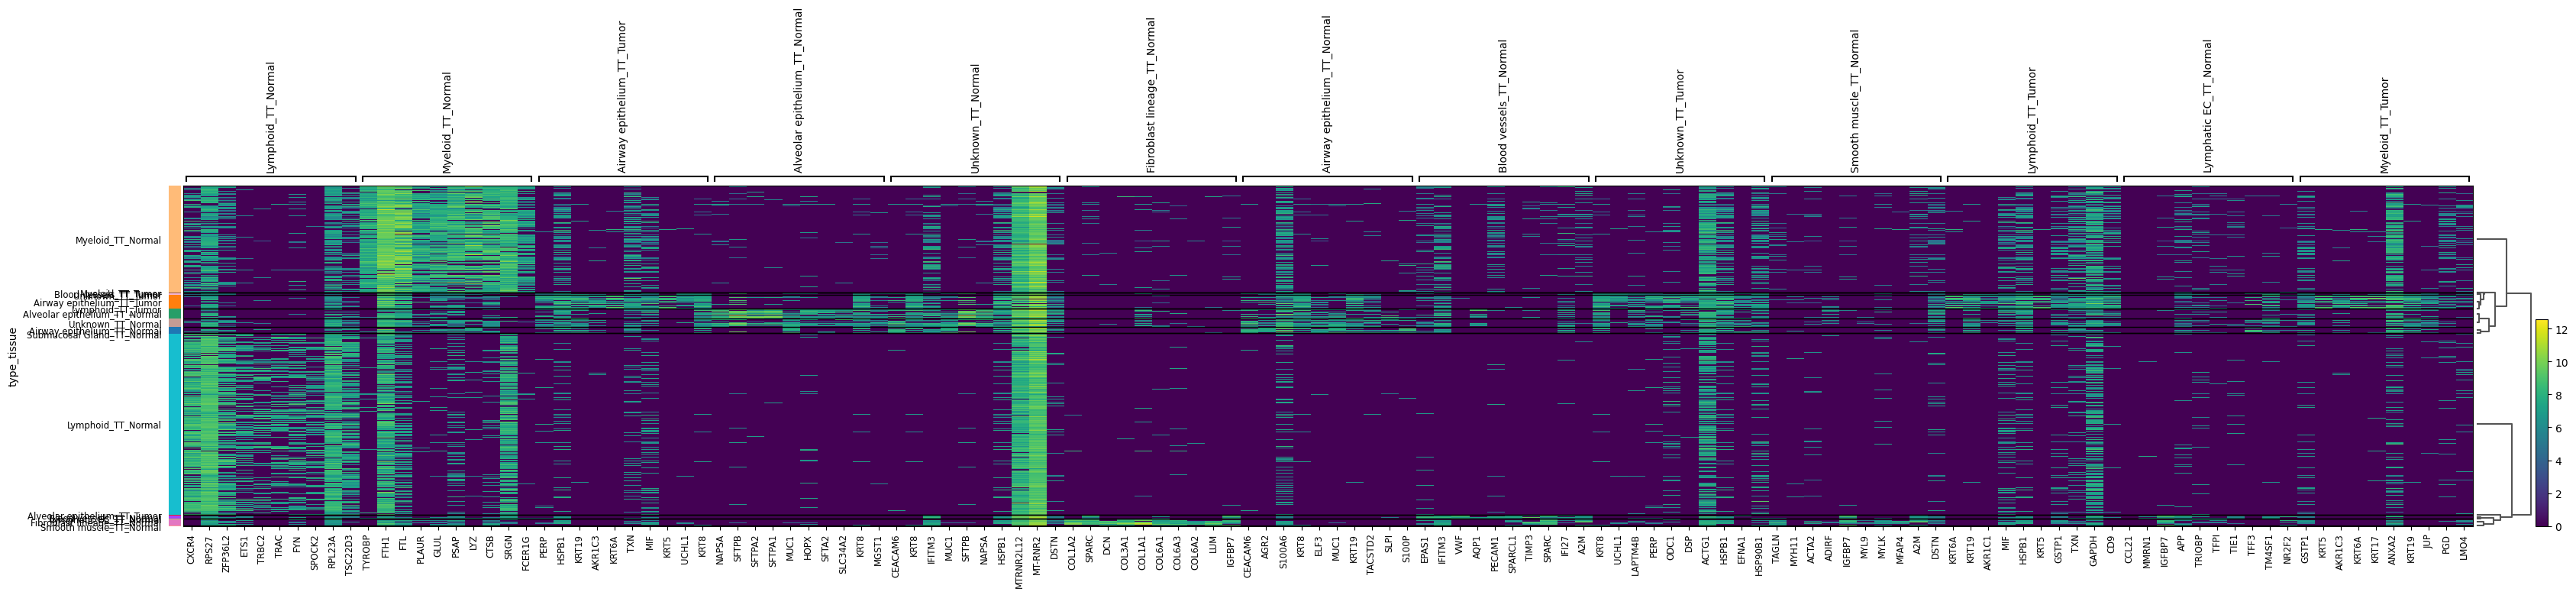

In [24]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [38]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [39]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [40]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [41]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str],
                 types: List[str], id_: str, load_gsea: bool = False,
                 key:str = 'rank_gene_groups', gsea_folder:str = 'gseapy_gsea') -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)
    dfs = []

    for type in types:
        ranks = adata.uns[key]
        type_path = type.replace('/','_')
        gsea_path = f'{gsea_folder}/{type_path}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: ranks['scores'][type][i] for i, gene in enumerate(ranks['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [45]:
%%time
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
combined_dfs = {}

for region in regions:
    gsea_path = f'{gsea_folder}/heatmap_{region}_{time}.csv'
    if load_gsea_heatmap:
        combined_dfs[region] = pd.read_csv(gsea_path, index_col=0)
    else:
        types = adata.uns[f'rank_genes_groups_{region}']['scores'].dtype.names
        combined_dfs[region] = get_gseas_df(adata, valid_types, types, id_, load_gsea=False, key=f'rank_genes_groups_{region}')
        combined_dfs[region].to_csv(gsea_path)

/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:37,876 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:38,663 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_145298/3327198433.py:40: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-06-14 23:56:39,269 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The orde

CPU times: user 3min 28s, sys: 14.7 s, total: 3min 43s
Wall time: 1min


In [33]:
combined_dfs[region]

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Tumor cells LUAD,1.385179,-1.000000,1.327392,0.898662,0.975571,0.961109,1.003821,1.019825,1.490762,1.176540,...,1.621359,1.415603,1.045800,0.911878,-1.000000,1.406214,1.120867,1.009145,0.765120,1.385751
Tumor cells LUAD EMT,0.962979,-1.698852,-1.297952,1.385156,-1.147256,-0.743597,-1.372340,-1.305298,1.018020,-1.013391,...,-1.006692,1.592662,0.633768,-1.293659,-1.720307,-1.067344,1.043090,-1.483855,0.973137,1.132077
Tumor cells LUAD MSLN,1.205333,0.721505,1.245030,1.239334,1.101454,1.045558,1.100449,1.054247,1.244188,1.131000,...,1.362180,1.048373,0.950002,1.072134,0.948464,1.235048,1.099807,1.140690,0.870975,1.185255
Tumor cells LUAD NE,1.108878,-1.000000,1.050197,0.676721,0.925393,1.060494,0.875229,0.997833,1.139776,0.572162,...,1.302258,1.096325,1.109654,0.900400,0.667036,1.315554,0.978590,1.028570,0.965479,1.106298
Tumor cells LUAD mitotic,1.211308,-1.000000,1.080180,-1.306534,0.976211,0.959492,1.129360,0.852761,1.355446,1.131085,...,1.435936,1.264051,1.229550,0.784730,-1.000000,1.191127,1.038920,1.032342,0.801956,1.146589
Tumor cells LUSC,1.362146,-2.268965,-1.004088,-1.060499,0.947719,1.162958,-1.052432,0.821036,1.308656,-1.234129,...,1.324436,1.636218,1.362052,-1.419960,-1.835468,1.059770,-0.952888,1.000061,0.781523,1.557828
Tumor cells LUSC mitotic,1.270469,-1.000000,0.935149,-1.296147,0.782493,1.078952,0.813501,0.940703,1.264724,-1.203123,...,1.263732,1.471365,1.576645,-1.160731,-1.000000,1.310929,-0.880739,1.057436,0.790173,1.289721
Tumor cells NSCLC mixed,-1.244759,-2.045948,1.075813,-1.245467,1.175175,1.340076,-1.038423,-0.833133,1.300499,1.010599,...,1.019497,-1.303180,-0.813187,-1.095983,-1.135068,-1.164943,-0.914398,-1.121742,-1.144146,-1.000073


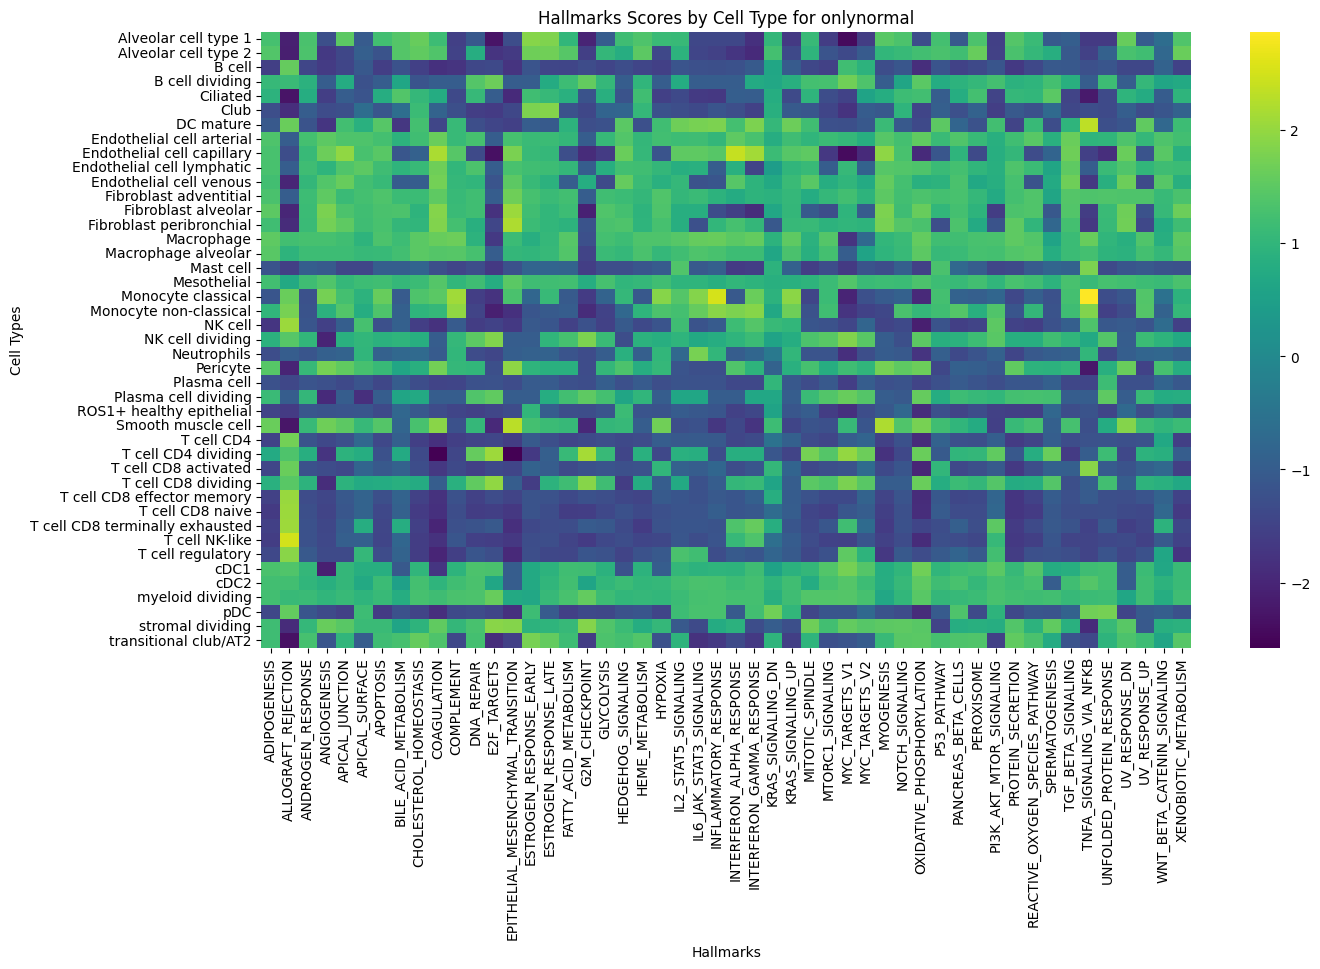

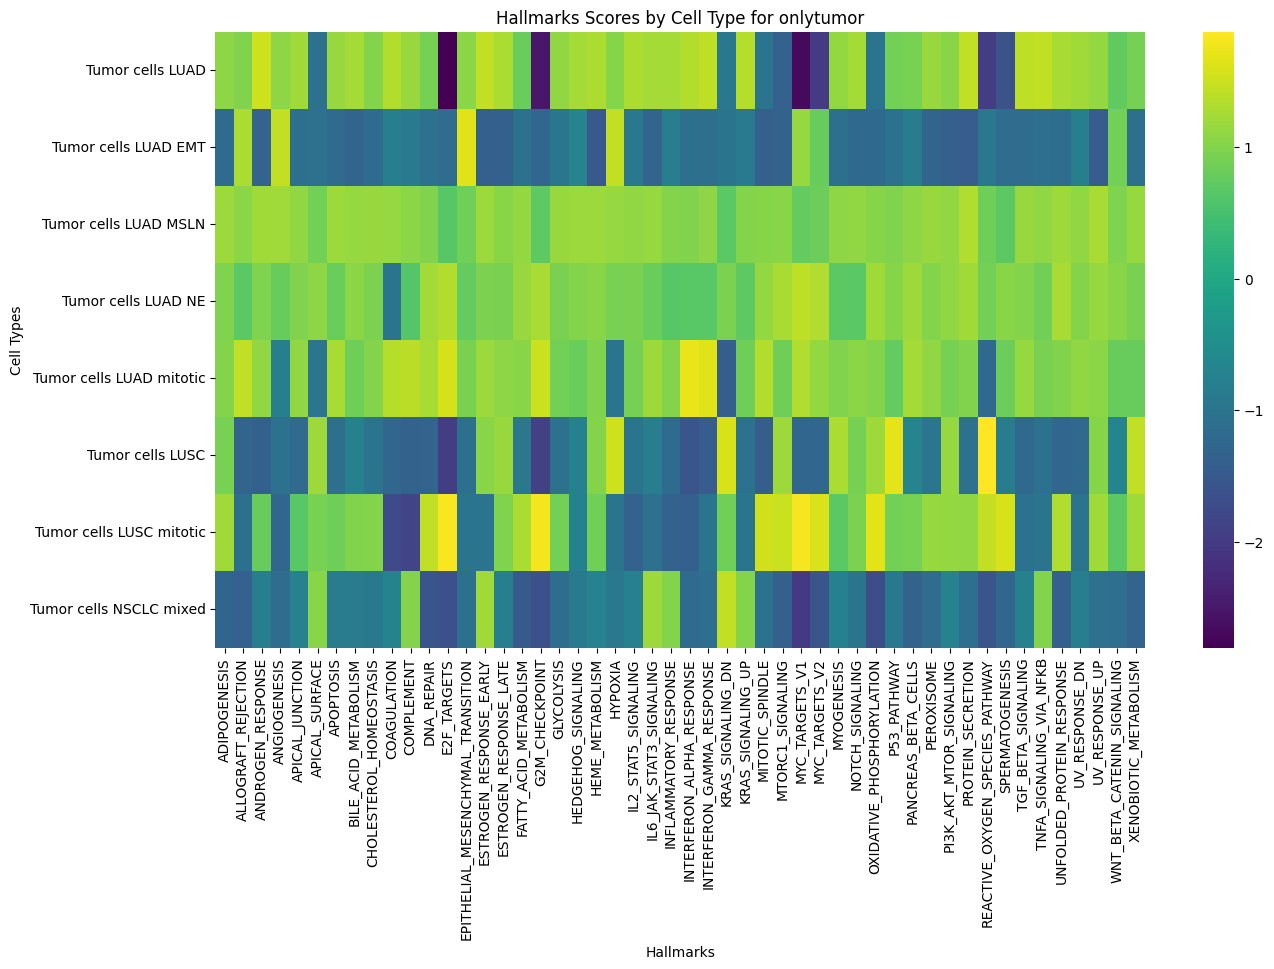

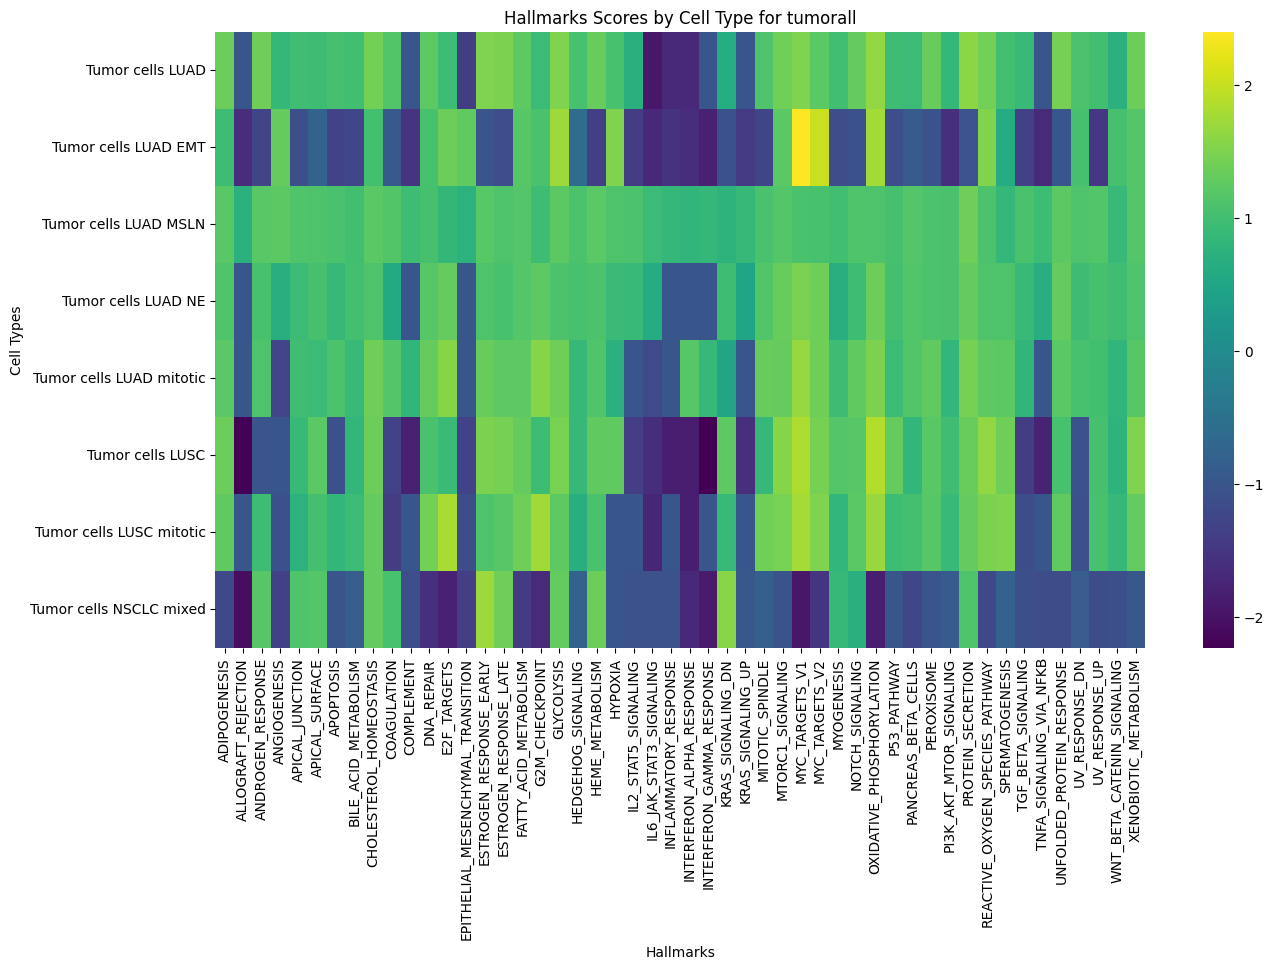

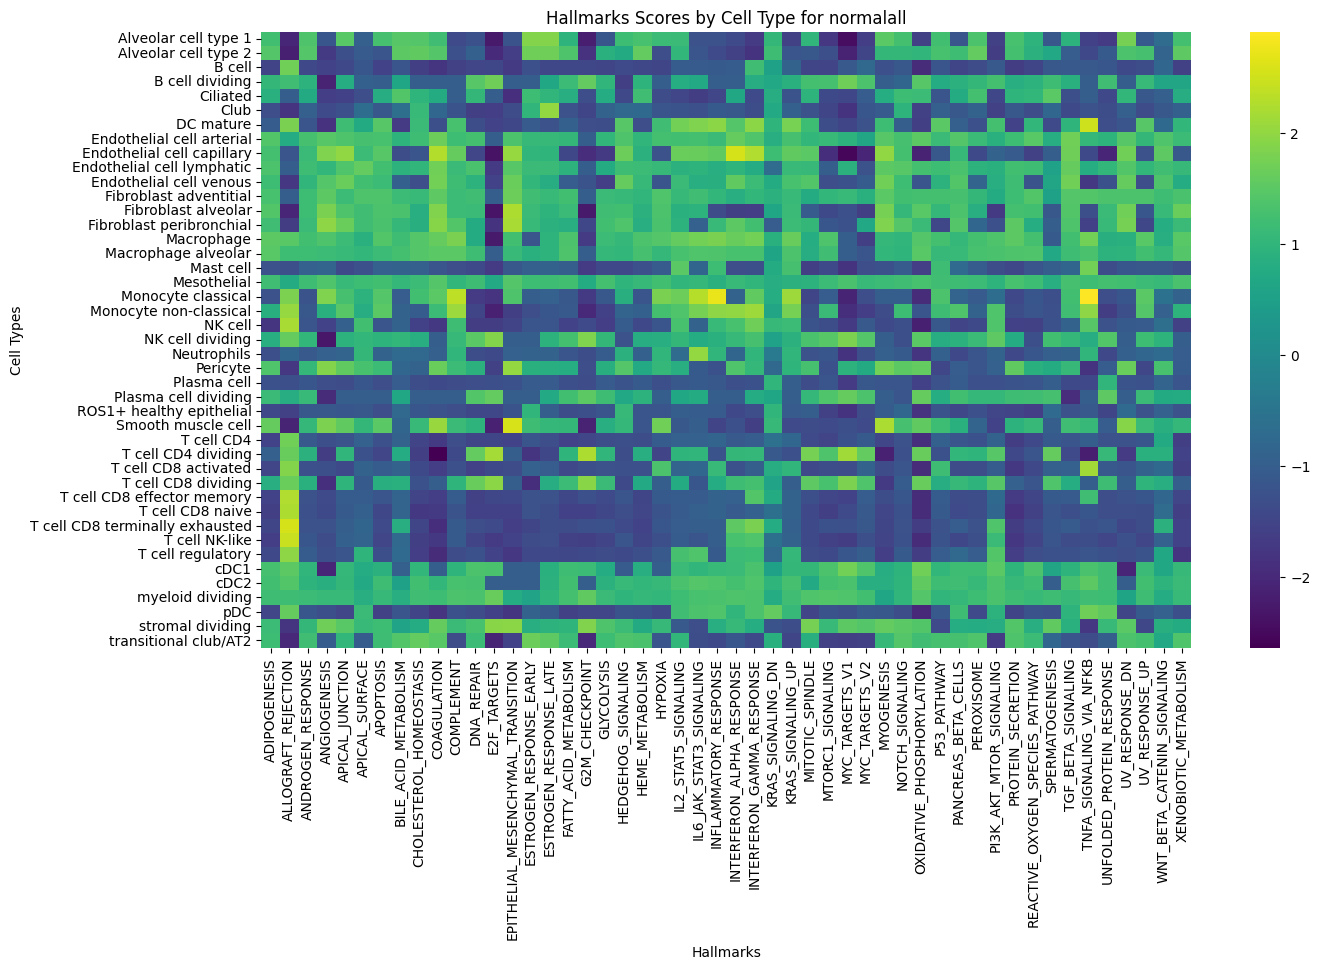

In [46]:
# Plotting the heatmap
# combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']
for region in regions:
    plt.figure(figsize=(15, 8))
    sns.heatmap(combined_dfs[region], cmap='viridis')
    plt.title(f'Hallmarks Scores by Cell Type for {region}')
    plt.xlabel('Hallmarks')
    plt.ylabel('Cell Types')
    plt.show()

## Pseudotime

In [90]:
adata_tumor

View of AnnData object with n_obs × n_vars = 46473 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'type_tissue',

In [104]:
sc.pl.draw_graph(adata_t_b)

KeyError: 'draw_graph'

In [ ]:
adata.obs['cell_type_tumor']

In [97]:
# adata_normal = adata[np.logical_not(adata.obs['cell_type_tumor'].str.contains('Tumor'))]
adata_t_b = adata[np.logical_or(adata.obs['cell_type_tumor'].str.contains('T cell'), adata.obs['cell_type_tumor'].str.contains('B cell'))]

In [98]:
sc.tl.diffmap(adata_t_b)

/usr/local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:933: RuntimeWarning: divide by zero encountered in divide
  Q = scipy.sparse.spdiags(1.0 / q, 0, W.shape[0], W.shape[0])
/usr/local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:943: RuntimeWarning: divide by zero encountered in divide
  self.Z = scipy.sparse.spdiags(1.0 / z, 0, K.shape[0], K.shape[0])


ArpackNoConvergence: ARPACK error -1: No convergence (504391 iterations, 2/15 eigenvectors converged)